In [19]:
# External modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import importlib
import numpy as np
import os, sys
import json
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../utils/'))

# Local modules
import get_oms_data
# importlib.reload(get_oms_data)  # not needed unless making live changes to the modules
from get_oms_data import get_oms_api, get_oms_data, get_oms_response_attribute

import json_utils as jsonu
import plot_utils as pu

import mplhep as hep
hep.style.use("CMS")

# import OMS_RR_utils
# importlib.reload(OMS_RR_utils) 
import json_utils
# import OMS_RR_utils as omsu
from refruns_utils import get_reference_run as RRfetch
import refrank_utils as rrr
import oms_utils as omsu

In [27]:
# importlib.reload(rrr)
importlib.reload(omsu)

<module 'oms_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/oms_utils.py'>

# Getting the Data
We start by instantiating the OMS API. The OMS API will be used to get Run and LS level data and will be the main source of information for the reference run ranking (RRR) system.

In [21]:
omsapi = get_oms_api()

In [22]:
# Run level attributes
run_attribs = [
    'components', 
    'init_lumi',
    'recorded_lumi', 
    'delivered_lumi',
    'start_time',
    'end_time',
    'energy', 
    'end_lumi', 
    'hlt_physics_rate',
    'fill_number', 
    'l1_hlt_mode', 
    'trigger_mode',
    'l1_key_stripped', 
    'fill_type_party2',
    'fill_type_party1', 
    'initial_prescale_index',
    'sequence', 
    'hlt_physics_size', 
    'fill_type_runtime',
    'last_lumisection_number', # refers to the last LSs where cms_active is True
    'l1_rate',
    'l1_menu', 
    'run_number',
    'stable_beam',
    'hlt_physics_counter',
]

# Lumisecion (LS) level attributes
ls_attribs = [
    'fill_number',
    "run_number",
    'lumisection_number',
    "physics_flag",
    "cms_active",
    'bpix_ready',
    'fpix_ready',
    'tecm_ready',
    'tecp_ready',
    'tibtid_ready',
    'tob_ready',
    'pileup',
    'delivered_lumi',
    'recorded_lumi',
    "init_lumi",
    'end_lumi',
    'beam1_stable',
    'beam2_stable',
    'beam2_present',
    'beam1_present',
#     "l1_rate" 
]

## Loading data

In [23]:
# Run we wish to certify and for which we will find a correspond reference run
newest_run = 316201
oldest_run = 314206

# All 2018 runs
# newest_run = 327802
# oldest_run = 308241

# Range of runs of interest
run_range = (oldest_run, newest_run)
print("Run range: {}".format(run_range))
print("Potential total number of runs to load: {}".format(newest_run - oldest_run))

Run range: (314206, 316201)
Potential total number of runs to load: 1995


In [34]:
run_df, ls_df = omsu.get_runs_lss(run_range, omsapi, run_attribs, ls_attribs)

https://vocms0185.cern.ch/agg/api/v1/runs/?fields=l1_menu,recorded_lumi,run_number,hlt_physics_counter,last_lumisection_number,l1_rate,sequence,init_lumi,stable_beam,end_lumi,energy,fill_type_party1,hlt_physics_size,start_time,fill_type_party2,hlt_physics_rate,l1_key_stripped,initial_prescale_index,fill_number,trigger_mode,l1_hlt_mode,components,delivered_lumi,end_time,fill_type_runtime&filter[run_number][GE]=314206&filter[run_number][LE]=316201&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1/runs/?fields=l1_menu,recorded_lumi,run_number,hlt_physics_counter,last_lumisection_number,l1_rate,sequence,init_lumi,stable_beam,end_lumi,energy,fill_type_party1,hlt_physics_size,start_time,fill_type_party2,hlt_physics_rate,l1_key_stripped,initial_prescale_index,fill_number,trigger_mode,l1_hlt_mode,components,delivered_lumi,end_time,fill_type_runtime&filter[run_number][GE]=314206&filter[run_number][LE]=316201&page[offset]=0&page[limit]=5000
https://vocms0185.cern.ch/agg/api/v1

In [44]:
get_oms_data??

In [110]:
# Optional: Save to parquet
run_df.to_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/run_df.parquet')
ls_df.to_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/ls_df.parquet')

In [6]:
# Optional: Load from parquet
run_df = pd.read_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/run_df.parquet')
ls_df = pd.read_parquet('/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/data/ls_df.parquet')

In [35]:
# Quick check of the loaded runs and LSs
print(len(run_df))
print(len(ls_df))

1231
62618


In [36]:
run_df[[
    "run_number", #
    "init_lumi", #
    "recorded_lumi",
    "energy",
    "end_lumi", #
    "hlt_physics_rate",
    "fill_number",
    "initial_prescale_index",
    "last_lumisection_number",
    "l1_rate",
    "hlt_physics_counter",
]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   run_number               1231 non-null   Int64  
 1   init_lumi                806 non-null    Float64
 2   recorded_lumi            802 non-null    Float64
 3   energy                   806 non-null    Int64  
 4   end_lumi                 806 non-null    Float64
 5   hlt_physics_rate         797 non-null    Float64
 6   fill_number              806 non-null    Int64  
 7   initial_prescale_index   821 non-null    Int64  
 8   last_lumisection_number  799 non-null    Int64  
 9   l1_rate                  819 non-null    Float64
 10  hlt_physics_counter      797 non-null    Int64  
dtypes: Float64(5), Int64(6)
memory usage: 119.1 KB


Some of the rows has `fill_number = NaN`. This is problematic, so we will segment the rows into those that have this problem (`run_df_NaN`), and the rest (`run_df`). We also add `Fill Location` column and make the `run_number` column into an index column.

<font color='red'> INVESTIGATE WHY THESE RUNS/LSs HAVE NaN VALUES. FIGURE WHERE THESE LSs TEND TO HAPPEN (START OR END OF THE RUN). </font>

In [37]:
# Filter out runs that have NaN in fill number
run_df, run_df_NaN = rrr.has_fill(run_df)
print(
    '''
    Runs kept in run dataframe: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(run_df['run_number'].unique()), 
        len(run_df_NaN['run_number'].unique()),
        run_df['run_number'].min(),
        run_df['run_number'].max())
)

run_df = rrr.add_loc_wrt_fill(run_df)

run_df.set_index(['run_number'], inplace=True)
run_df.sort_index(level=['run_number'], inplace=True)


    Runs kept in run dataframe: 806
    Runs filtered out: 425
    Lowest run # kept: 314206
    Highest run # kept: 316201
    


/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/refrank_utils.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcopy['Fill location'].iloc[count]="({}/{})".format(x,i)


In [39]:
# Filter out LSs that have NaN values
ls_df, ls_df_NaN = rrr.has_fill(ls_df)
print(
    '''
    Runs kept in lumisection dataframe: {}
    Runs filtered out: {}
    Lowest run # kept: {}
    Highest run # kept: {}
    '''.format(
        len(ls_df['run_number'].unique()),   
        len(ls_df_NaN['run_number'].unique()),
        ls_df['run_number'].min(),
        ls_df['run_number'].max()
    )
)

ls_df = rrr.add_loc_wrt_fill(ls_df)
ls_df = ls_df.convert_dtypes()

ls_df.set_index(['run_number', 'lumisection_number'], inplace=True)
ls_df.sort_index(level=['run_number', 'lumisection_number'], inplace=True)


    Runs kept in lumisection dataframe: 407
    Runs filtered out: 13
    Lowest run # kept: 315206
    Highest run # kept: 316201
    


/eos/home-i02/r/rcruzcan/SWAN_projects/RefRunRank/utils/refrank_utils.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcopy['Fill location'].iloc[count]="({}/{})".format(x,i)


We are now left with cleaner dataframes.

In [11]:
run_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 806 entries, 314206 to 316201
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   components               806 non-null    object 
 1   init_lumi                806 non-null    Float64
 2   recorded_lumi            802 non-null    Float64
 3   delivered_lumi           802 non-null    Float64
 4   energy                   806 non-null    Int64  
 5   end_lumi                 806 non-null    Float64
 6   hlt_physics_rate         737 non-null    Float64
 7   fill_number              806 non-null    Int64  
 8   l1_hlt_mode              806 non-null    string 
 9   end_time                 806 non-null    string 
 10  trigger_mode             806 non-null    string 
 11  l1_key_stripped          806 non-null    string 
 12  fill_type_party2         806 non-null    string 
 13  fill_type_party1         806 non-null    string 
 14  initial_prescale_index 

In [12]:
ls_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 99234 entries, (314206, 1) to (316082, 213)
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fill_number     99234 non-null  Int64  
 1   beam1_present   99234 non-null  boolean
 2   physics_flag    99234 non-null  boolean
 3   tecp_ready      99234 non-null  boolean
 4   bpix_ready      99234 non-null  boolean
 5   tecm_ready      99234 non-null  boolean
 6   cms_active      99234 non-null  boolean
 7   tibtid_ready    99234 non-null  boolean
 8   fpix_ready      99234 non-null  boolean
 9   beam1_stable    99234 non-null  boolean
 10  tob_ready       99234 non-null  boolean
 11  init_lumi       98927 non-null  Float64
 12  pileup          98926 non-null  Float64
 13  recorded_lumi   98927 non-null  Float64
 14  delivered_lumi  98927 non-null  Float64
 15  beam2_stable    99234 non-null  boolean
 16  end_lumi        98927 non-null  Float64
 17  beam2_present

In [40]:
# Checking which runs appear in one dataframe, but not the other, and dropping them from both dataframes.

rundf_runs = run_df.index.to_list()
lsdf_runs = ls_df.index.get_level_values(0)

# Finding symmetric different
missing_runs = list(set(rundf_runs) ^ set(lsdf_runs))
print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)

# Going through each dataframe and deleting these runs
for run in missing_runs:
    if run in rundf_runs:
        run_df.drop(run, inplace=True)
    else:
        ls_df.drop(run, inplace=True)


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    [316100, 314206, 314210, 314215, 314217, 314221, 314225, 314226, 314227, 314228, 314229, 314230, 314235, 314240, 314241, 314242, 314243, 314244, 314245, 314246, 314247, 314248, 314249, 314250, 314255, 314267, 314269, 314270, 314272, 314273, 314274, 314275, 314276, 314277, 314278, 314280, 314281, 314283, 314288, 314290, 314297, 314299, 314304, 314307, 314309, 314312, 314315, 314321, 314322, 314324, 314325, 314327, 314328, 314329, 314331, 314332, 314333, 314334, 314336, 314337, 314340, 314341, 314344, 314346, 314348, 314349, 314350, 314351, 314352, 314353, 314354, 314355, 314356, 314357, 314359, 314360, 314361, 314362, 314363, 314389, 314397, 314402, 314403, 314405, 314410, 314412, 314416, 314428, 314435, 314436, 314439, 314441, 314442, 314443, 314444, 314446, 314447, 314448, 314449, 314450, 314451, 314453, 314454, 314455, 314458, 314465, 314470, 314471, 314472, 314473, 314474, 314475, 314476, 3

In [41]:
# Sanity check that the run filtering step worked

rundf_runs = run_df.index.to_list()
lsdf_runs = ls_df.index.get_level_values(0)

# Finding symmetric different
missing_runs = list(set(rundf_runs) ^ set(lsdf_runs))
print(
    '''
    List of runs which are in one of the dataframes, but not the other (and viceversa): \n    {}
    '''.format(missing_runs)
)


    List of runs which are in one of the dataframes, but not the other (and viceversa): 
    []
    


In [42]:
print(
    '''
    Number of runs in the run dataframe: {}
    Number of runs in the lumisection dataframe: {}
    Are the runs contained in these dataframes exactly the same?: {}
    '''.format(
        len(run_df.index.unique()),
        len(ls_df.index.get_level_values(0).unique()),
        run_df.index.unique().tolist() == ls_df.index.get_level_values(0).unique().tolist()
    )
)


    Number of runs in the run dataframe: 407
    Number of runs in the lumisection dataframe: 407
    Are the runs contained in these dataframes exactly the same?: True
    


In [43]:
run_df.head()

,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,end_time,...,sequence,start_time,hlt_physics_size,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location
run_number,,,,,,,,,,,,,,,,,,,,,
315206,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,80.402,6615,cosmics2018,2018-04-26T09:35:38Z,...,GLOBAL-RUN,2018-04-26T09:04:28Z,8.699,COSMICS,79,790.65,L1Menu_Collisions2018_0_0_1,False,148063,(5/42)
315210,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,76.502,6615,cosmics2018,2018-04-26T10:19:56Z,...,GLOBAL-RUN,2018-04-26T09:37:52Z,11.105,COSMICS,106,784.692,L1Menu_Collisions2018_0_0_1,False,189028,(6/42)
315214,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,6.757,6615,cosmics2018,2018-04-26T10:36:38Z,...,GLOBAL-RUN,2018-04-26T10:35:15Z,0.006,COSMICS,2,492.901,L1Menu_Collisions2018_0_0_1,False,315,(7/42)
315215,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,0.06,6615,circulating2018,2018-04-26T10:47:18Z,...,GLOBAL-RUN,2018-04-26T10:43:07Z,0.002,PROTONS,9,21.965,L1Menu_Collisions2018_0_0_1,False,7,(8/42)
315216,"[CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECAL, ES...",0.0,0.0,0.0,0,0.0,3.405,6615,circulating2018,2018-04-26T11:17:38Z,...,GLOBAL-RUN,2018-04-26T10:50:56Z,0.178,PROTONS,67,978.848,L1Menu_Collisions2018_0_0_1,False,5318,(9/42)


In [17]:
ls_df.head()

fill_number  beam1_present  physics_flag  \
run_number lumisection_number                                             
314206     1                          6554           True         False   
           2                          6554           True         False   
           3                          6554           True         False   
           4                          6554           True         False   
           5                          6554           True         False   

                               tecp_ready  bpix_ready  tecm_ready  cms_active  \
run_number lumisection_number                                                   
314206     1                        False       False       False        True   
           2                        False       False       False        True   
           3                        False       False       False        True   
           4                        False       False       False        True   
           5                        False       False       False        True   

                               tibtid_ready  fpix_ready  beam1_stable  \
run_number lumisection_number                                           
314206     1                          False       False         False   
           2                          False       False         False   
           3                          False       False         False   
           4                          False       False         False   
           5                          False       False         False   

                               tob_ready  init_lumi  pileup  recorded_lumi  \
run_number lumisection_number                                                
314206     1                       False   0.000926     0.0            0.0   
           2                       False   0.000924     0.0            0.0   
           3                       False   0.000923     0.0            0.0   
           4                       False   0.000928     0.0            0.0   
           5                       False   0.000922     0.0            0.0   

                               delivered_lumi  beam2_stable  end_lumi  \
run_number lumisection_number                                           
314206     1                              0.0         False  0.000924   
           2                              0.0         False  0.000923   
           3                              0.0         False  0.000928   
           4                              0.0         False  0.000922   
           5                              0.0         False  0.000919   

                               beam2_present Fill location  
run_number lumisection_number                               
314206     1                            True      (1/2031)  
           2                            True      (2/2031)  
           3                            True      (3/2031)  
           4                            True      (4/2031)  
           5                            True      (5/2031)

# Filtering Good & Collisions Runs/LSs

Note: It might be neccesary to generate a new golden JSON in RR depending on the range of runs chosen for ranking.

In [18]:
# Relevant golden jsons available in the json directory
golden_files = [
    'json_GOLDEN_2017.json', 
    'json_GOLDEN_2018.json',
    'json_GOLDEN_RRRdev.json',
    'json_TRK_PromptReco_314324to316201.json',
]

Generated golden JSON such as `json_GOLDEN_RRRdev.json` made in RR using input similar to:
```json
{
  "and": [
    {">=": [{"var": "run.oms.run_number"}, 315190]},
    {"<=": [{"var": "run.oms.run_number"}, 316201]},
    {"==": [{"var": "lumisection.rr.tracker-pixel"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-strip"}, "GOOD"]},
    {"==": [{"var": "lumisection.rr.tracker-track"}, "GOOD"]}
  ]
}
```


In [19]:
# We now get collision runs/LSs
runcoll_df, lscoll_df, runnotcoll_df, lsnotcoll_df = omsu.get_collisions(run_df.reset_index(), ls_df.reset_index())

In [20]:
print(
    '''
        We originally had this amount of runs:    {}
        Amount of these runs that are collisions: {}
    '''.format(len(runcoll_df['run_number'].tolist()) + len(runnotcoll_df['run_number'].tolist()),
              len(runcoll_df['run_number'].unique()))
)
    


        We originally had this amount of runs:    750
        Amount of these runs that are collisions: 266
    


In [21]:
print(
    '''
    Number of runs in collision dataframe:                   {}
    Number of runs in LS dataframe:                          {}
    Runs that are in one, but not the other (and viceversa): {}
    '''.format(
        len(runcoll_df['run_number'].unique()),
        len(lscoll_df['run_number'].unique()),
        list(set(runcoll_df['run_number'].tolist()) ^ set(lscoll_df['run_number'].unique().tolist()))
    )
)


    Number of runs in collision dataframe:                   266
    Number of runs in LS dataframe:                          266
    Runs that are in one, but not the other (and viceversa): []
    


In [22]:
# Dividing good runs/LSs from bad runs/LSs
good_mask = json_utils.injson(
    np.array(lscoll_df['run_number']), 
    np.array(lscoll_df['lumisection_number']), 
    '/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/'+golden_files[3])

lscollgood_df = lscoll_df[good_mask]
lscollbad_df = lscoll_df[~good_mask]

runcollgood_df = runcoll_df[runcoll_df['run_number'].isin(lscollgood_df['run_number'].unique())]
runcollbad_df = runcoll_df[~runcoll_df['run_number'].isin(lscollgood_df['run_number'].unique())]

print(
    '''
        Number of good collision LSs: {}
        Number of bad collisions LSs: {}
    '''.format(len(lscollgood_df), len(lscollbad_df))
)

print(
    '''
        Number of good collision LSs: {}
        Number of bad collisions LSs: {}
    '''.format(len(runcollgood_df), len(runcollbad_df))
)


        Number of good collision LSs: 42365
        Number of bad collisions LSs: 8647
    

        Number of good collision LSs: 186
        Number of bad collisions LSs: 80
    


<h3>Data Exploration</h3>

We create some plots to better understand how this data looks like

In [23]:
lumi_info = lscollgood_df[['run_number',
                           'init_lumi', 
                           'end_lumi',
                           'pileup',
                           'recorded_lumi', 
                           'delivered_lumi',
                           'lumisection_number',]]
lumi_info

,run_number,init_lumi,end_lumi,pileup,recorded_lumi,delivered_lumi,lumisection_number
13773,314472,0.0,0.0,0.00411,0.0,0.0,1
13774,314472,0.0,0.0,0.003523,0.0,0.0,2
13775,314472,0.0,0.0,0.014386,0.0,0.0,3
13776,314472,0.0,0.0,0.010276,0.0,0.0,4
13777,314472,0.0,0.0,0.012331,0.0,0.0,5
...,...,...,...,...,...,...,...
99229,316082,1.673123,1.672632,46.804588,66.08157,68.426563,209
99230,316082,1.672632,1.671218,46.790833,66.463313,68.81618,210
99231,316082,1.671218,1.671056,46.751289,66.845086,69.205766,211
99232,316082,1.671056,1.670529,46.746773,67.226547,69.595086,212


/tmp/ipykernel_531/1385621406.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lumi_info['run_lumisection'] = list(zip(lumi_info['run_number'], lumi_info['lumisection_number']))


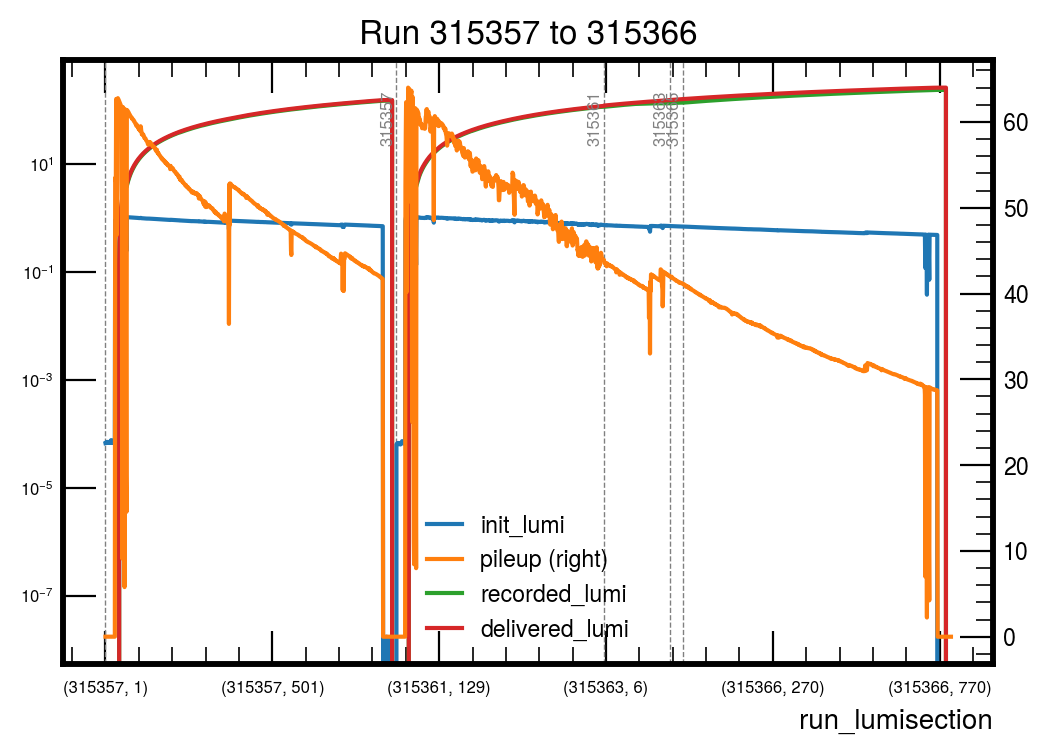

In [24]:
# Plotting init_lumi, pileup, recorded_lumi and delivered_lumi for a couple of runs

run_begin = 315357
run_end = 315366

lumi_info['run_lumisection'] = list(zip(lumi_info['run_number'], lumi_info['lumisection_number']))

filtered_lumi_info = lumi_info[(lumi_info['run_number'] >= run_begin) & (lumi_info['run_number'] <= run_end)]

fig, ax = plt.subplots(dpi=200)

current_run = None
for idx, (run, lumisection) in enumerate(filtered_lumi_info['run_lumisection']):
    if run != current_run:
        ax.axvline(x=idx, color='gray', linestyle='--', linewidth=0.5)  # Add a vertical line
        
        # Add a label for the run number
        if current_run is not None:  # Skip label for the very first line
            label_x_position = idx - 1  # Adjust this as needed to position the label correctly
            ax.text(label_x_position, 0.95, str(current_run), transform=ax.get_xaxis_transform(), 
                    horizontalalignment='right', verticalalignment='top', fontsize=6, color='gray', rotation='vertical')
            
        current_run = run
        
        
features_to_plot = [
    'init_lumi', 
    'pileup', 
    'recorded_lumi', 
    'delivered_lumi'
]

filtered_lumi_info.plot(x='run_lumisection', y=features_to_plot, secondary_y='pileup', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_yscale('log')
plt.title(f"Run {run_begin} to {run_end}")
plt.show()

In [25]:
runcollgood_df[runcollgood_df['run_number']==315357]

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,sequence,start_time,hlt_physics_size,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location
470,315357,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.065461,151.544641,155.624266,6499,0.0,998.688,6620,collisions2018,...,GLOBAL-RUN,2018-04-28T19:14:57Z,18549.289,PROTONS,848,32758.156,L1Menu_Collisions2018_0_0_1,True,19741299,(4/4)


In [26]:
lscollgood_df[lscollgood_df['run_number']==315357].head(50)

,run_number,lumisection_number,fill_number,beam1_present,physics_flag,tecp_ready,bpix_ready,tecm_ready,cms_active,tibtid_ready,...,beam1_stable,tob_ready,init_lumi,pileup,recorded_lumi,delivered_lumi,beam2_stable,end_lumi,beam2_present,Fill location
55687,315357,1,6620,True,False,False,False,False,True,False,...,False,False,0.000067,0.003932,0.0,0.0,False,0.000067,True,(393/1248)
55688,315357,2,6620,True,False,False,False,False,True,False,...,False,False,0.000067,0.003945,0.0,0.0,False,0.00007,True,(394/1248)
55689,315357,3,6620,True,False,False,False,False,True,False,...,False,False,0.00007,0.004077,0.0,0.0,False,0.000069,True,(395/1248)
55690,315357,4,6620,True,False,False,False,False,True,False,...,False,False,0.000069,0.004046,0.0,0.0,False,0.00007,True,(396/1248)
55691,315357,5,6620,True,False,False,False,False,True,False,...,False,False,0.00007,0.004108,0.0,0.0,False,0.000071,True,(397/1248)
55692,315357,6,6620,True,False,False,False,False,True,False,...,False,False,0.000071,0.004152,0.0,0.0,False,0.00007,True,(398/1248)
55693,315357,7,6620,True,False,False,False,False,True,False,...,False,False,0.00007,0.004087,0.0,0.0,False,0.000071,True,(399/1248)
55694,315357,8,6620,True,False,False,False,False,True,False,...,False,False,0.000071,0.004165,0.0,0.0,False,0.000068,True,(400/1248)
55695,315357,9,6620,True,False,False,False,False,True,False,...,False,False,0.000068,0.003986,0.0,0.0,False,0.000069,True,(401/1248)
55696,315357,10,6620,True,False,False,False,False,True,False,...,False,False,0.000069,0.004066,0.0,0.0,False,0.00007,True,(402/1248)


In [27]:
lumi_info[(lumi_info['run_number'] >= run_begin) & (lumi_info['run_number'] <= run_end)].set_index('run_number')

,init_lumi,end_lumi,pileup,recorded_lumi,delivered_lumi,lumisection_number,run_lumisection
run_number,,,,,,,
315357,0.000067,0.000067,0.003932,0.0,0.0,1,"(315357, 1)"
315357,0.000067,0.00007,0.003945,0.0,0.0,2,"(315357, 2)"
315357,0.00007,0.000069,0.004077,0.0,0.0,3,"(315357, 3)"
315357,0.000069,0.00007,0.004046,0.0,0.0,4,"(315357, 4)"
315357,0.00007,0.000071,0.004108,0.0,0.0,5,"(315357, 5)"
...,...,...,...,...,...,...,...
315366,0.0,0.0,0.0,0.0,0.0,800,"(315366, 800)"
315366,0.0,0.0,0.0,0.0,0.0,801,"(315366, 801)"
315366,0.0,0.0,0.0,0.0,0.0,802,"(315366, 802)"


In [ ]:

# lscoll_df[lscoll_df['run_number']].plot(y=['recorded_lumi','delivered_lumi','pileup'],style='-',figsize=(20,9),logy=False,logx=False,secondary_y="pileup")
lscollgood_df[lscollgood_df['run_number'] < 315270].plot(y=['recorded_lumi','delivered_lumi','pileup'],style='-',figsize=(20,9),logy=False,logx=False,secondary_y="pileup")
# plt.xlim((0,3800))
plt.show()
# lsdf_collisions.plot(y=['init_lumi','end_lumi'],x='run_number' ,figsize=(19,9),logy=False,logx=False)

In [ ]:
lscollgood_df['run_number'].unique()

In [ ]:
fig, ax = plt.subplots(dpi=150)
lscollgood_df[lscollgood_df['run_number'] <= 315264].reset_index().plot(y=['recorded_lumi', 'delivered_lumi', 'pileup'], ax=ax)

plt.show()

In [ ]:
lscollgood_df[lscollgood_df['run_number'] == 315259][['recorded_lumi', 'delivered_lumi', 'pileup']]

In [ ]:
lscollgood_df[lscollgood_df['run_number'] <= 315265].reset_index()

In [ ]:
fig, ax = plt.subplots(dpi=200)

runcollgood_df.plot(y=['recorded_lumi',"delivered_lumi"], x="run_number",
                kind="bar", figsize=(19,9), logy=False, logx=False, ax=ax);

# Previously Developed Ranking Systems

In [28]:
# Turn off warnings for pandas
pd.options.mode.chained_assignment = None

<h2> Pre-existing RRR systems </h2>

The implementations previously developed used a dictionary as input where the elements of the dictionary were the run and LS dataframes. Therefore, we create such a dictionary.

In [ ]:
# Making the dictionary out of dataframes
data_dict = {'runs': runcollgood_df.reset_index(), 'lumisections': lscollgood_df.reset_index()}

In [ ]:
# # Run we wish to certify and for which we will find a correspond reference run
# target = 316201
# oldest_run = target - 1011

# # Range of runs of interest
# run_range = (oldest_run, target)
# print(run_range)

We also fetch the actual RR used for the certification of the target run.

In [ ]:
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
print('Actual RR used: ' + str(targetRR))

<h3> Version 1 </h3>
Version 1 of the RRR system gives a rank to each of the runs given by the following equation. (Note: In the original proposed version 1, the equation is slighly altered. The equation shown here is the one found in the actual implementation.)

$$
    G_1 = 0.5 *(\text{inst lumi delta }\%)  + 0.25 *(\text{pileup delta }\%) + 0.25 *(\text{run number delta } \%)
$$

where
- $\text{quantity %} = \frac{\text{possible ref quantity}-\text{target quantity}}{\text{target quantity}} * 100$

In [ ]:
v1_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V1').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v1_ranking.reset_index(inplace=True)
v1_ranking

We now evaluate how well this ranking system is by checking which run was actually used as reference.

In [ ]:
print('Ranking of actual RR used for target:', list(np.where(v1_ranking['run_number'] == targetRR))[0][0])

<h3> Version 2 </h3>
The equation used in this version to compute the ranking is given by
$$
    G_2 = 0.5 * \frac{\text{(inst lumi %)} * \text{(run inst lumi)}}{100 * \text{(ave inst lumi)}} + 0.25 * \frac{\text{(pileup %)}}{\text{(run pileup)}} + 0.25 * \frac{\text{(run number %)}}{\text{(run num)}}
$$

In [ ]:
v2_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V2').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v2_ranking.reset_index(inplace=True)
v2_ranking

In [ ]:
print('Ranking of actual RR used for target:', list(np.where(v2_ranking['run_number'] == targetRR))[0][0])

<h3> Version 3 </h3>
The equation used for this version is given by
$$
    G_3 = \frac{\text{inst lumi delta %}}{100} + \frac{\text{pileup delta %}}{100} + \frac{\text{run num delta}}{100} + \frac{\text{num of lumi delta %}}{100}
$$

In [ ]:
v3_ranking = omsu.ref_rank(data_dict, target, Trim=False, ver='V3').set_index('run_number') \
    .sort_values(by=["Run_Rank","inst_lumi_delta %",'pileup_delta %','run_number_delta'], key=lambda x: x.abs(), ascending=True)
v3_ranking.reset_index(inplace=True)
v3_ranking

In [ ]:
print('Ranking of actual RR used for target:', list(np.where(v3_ranking['run_number'] == targetRR))[0][0])

# Reference Run Ranking Using PCA

In [29]:
# Turn off warnings for pandas
pd.options.mode.chained_assignment = None

We observe the features available for PCA, find how they are correlated and their weights (given by the coefficients in the first PC), and then try using PCA to rank runs.

In [30]:
print("Run level features: \n{}\n".format(runcollgood_df.iloc[0]))
print("LS level features: \n{}".format(lscollgood_df.iloc[0]))

Run level features: 
run_number                                                            314472
components                 [CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...
init_lumi                                                           0.001623
recorded_lumi                                                       0.009077
delivered_lumi                                                      0.011048
energy                                                                  6499
end_lumi                                                            0.001572
hlt_physics_rate                                                    1649.849
fill_number                                                             6570
l1_hlt_mode                                                   collisions2018
end_time                                                2018-04-17T11:07:13Z
trigger_mode                                       l1_hlt_collisions2018/v22
l1_key_stripped                                        

## Run Level Features
PCA compatible features that can be considered are
- `run_number`
- `init_lumi`
- `recorded_lumi`
- `energy`
- `end_lumi`
- `hlt_physics_rate`
- `fill_number`
- `initial_prescale_index`
- `last_lumisection_number`
- `l1_rate`
- `hlt_physics_counter`

Features that we could calculate
- `delta_lumi` (change in lumi)
- `temp_dist` (how far back in time a run is with respect to the target run)

In this section we study these features.

In [31]:
runcollgood_df.tail(3)

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,sequence,start_time,hlt_physics_size,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location
738,316061,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.698097,9.896375,11.908156,6499,0.717717,312.891,6662,collisions2018,...,GLOBAL-RUN,2018-05-10T08:59:20Z,457.636,PROTONS,206,31555.443,L1Menu_Collisions2018_v1_0_0,True,1502485,(12/13)
739,316062,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.717256,3.613719,3.830469,6499,0.708778,293.151,6662,collisions2018,...,GLOBAL-RUN,2018-05-10T10:23:10Z,58.51,PROTONS,26,21189.146,L1Menu_Collisions2018_v1_0_0,True,177670,(13/13)
749,316082,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",1.881687,137.502563,142.084781,6499,1.542417,1142.772,6663,collisions2018,...,GLOBAL-RUN,2018-05-10T12:31:07Z,10760.964,PROTONS,433,51408.74,L1Menu_Collisions2018_v1_0_0,True,11534466,(10/10)


In [32]:
# Getting total change in lumi

runcollgood_df = rrr.comp_delta_totallumi(runcollgood_df)

# Getting temporal distance of each run with respect to the target run
# Changes each time we choose a different target run!
runcollgood_df = rrr.comp_temp_dist(runcollgood_df, 316062) 

# Getting duration
runcollgood_df = rrr.comp_duration(runcollgood_df)
runcollgood_df.head(3)

# TODO: Compute peak pileup

,run_number,components,init_lumi,recorded_lumi,delivered_lumi,energy,end_lumi,hlt_physics_rate,fill_number,l1_hlt_mode,...,fill_type_runtime,last_lumisection_number,l1_rate,l1_menu,stable_beam,hlt_physics_counter,Fill location,delta_totallumi,temp_dist,duration
107,314472,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.001623,0.009077,0.011048,6499,0.001572,1649.849,6570,collisions2018,...,PROTONS,85,36146.52,L1Menu_Collisions2018_0_0_1,True,3230527,(5/48),-0.000051,1986562.0,2005.0
108,314473,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.001552,0.00427,0.006126,6499,0.001536,2900.216,6570,collisions2018,...,PROTONS,13,39206.13,L1Menu_Collisions2018_0_0_1,True,878868,(6/48),-0.000015,1984511.0,333.0
109,314474,"[CSC, CTPPS, CTPPS_TOT, DAQ, DCS, DQM, DT, ECA...",0.001525,0.004117,0.006015,6499,0.001509,3086.0,6570,collisions2018,...,PROTONS,12,41741.863,L1Menu_Collisions2018_0_0_1,True,863231,(7/48),-0.000016,1984098.0,323.0


In [ ]:
runcollgood_df.tail(3)

We will now see how all of these variables are correlated and will also determine the weights of each of them relative to each other using the first component of PCA.

In [33]:
# Run level features that are compatible with PCA
runfeaturelst = [
    "run_number", #
    "init_lumi", #
    "recorded_lumi",
    "energy",
    "end_lumi", #
    "hlt_physics_rate",
    "fill_number",
    "initial_prescale_index",
    "last_lumisection_number",
    "l1_rate",
    "hlt_physics_counter",
    "delta_totallumi", #
    "temp_dist", #
    "delivered_lumi" #
]

run_features = runcollgood_df[runfeaturelst].astype(float).fillna(0)
run_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 107 to 749
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   run_number               186 non-null    float64
 1   init_lumi                186 non-null    float64
 2   recorded_lumi            186 non-null    float64
 3   energy                   186 non-null    float64
 4   end_lumi                 186 non-null    float64
 5   hlt_physics_rate         186 non-null    float64
 6   fill_number              186 non-null    float64
 7   initial_prescale_index   186 non-null    float64
 8   last_lumisection_number  186 non-null    float64
 9   l1_rate                  186 non-null    float64
 10  hlt_physics_counter      186 non-null    float64
 11  delta_totallumi          186 non-null    float64
 12  temp_dist                186 non-null    float64
 13  delivered_lumi           186 non-null    float64
dtypes: float64(14)
memory us

In [34]:
# Get the weights by taking the first principal component
weights = rrr.get_weights(run_features, plot=False)

In [37]:
# Organizing features by order of imporant
featureweights_dict = {feature: round(weight, 4) for feature, weight in zip(runfeaturelst, weights)}
featureweights_df = pd.DataFrame(list(featureweights_dict.items()), columns=["Feature", "Weight"]).sort_values("Weight", ascending=False).reset_index(drop=True)
featureweights_df

,Feature,Weight
0,temp_dist,0.1337
1,run_number,0.1333
2,fill_number,0.1324
3,init_lumi,0.1298
4,delivered_lumi,0.1038
5,recorded_lumi,0.1019
6,end_lumi,0.0789
7,last_lumisection_number,0.0642
8,delta_totallumi,0.0494
9,hlt_physics_rate,0.0464


Observations:
- `temp_dist`, `run_number` and `fill_number` are highly correlated. 
- `recorded_lumi` and `recorded_lumi` are highly correlated
- `energy`, `l1_rate`, `hlt_physics_counter` are very unimportant
- `last_lumisection_number` just tells us how long a run is. This is not relevant at this stage, so it is ignored for ranking.

In [43]:
# Looking only at relevant and non-highly correlated features
reducedfeaturelist = ["init_lumi", "end_lumi", "delta_totallumi", "hlt_physics_rate"]
weights_reduced = rrr.get_weights(run_features[reducedfeaturelist], plot=False)

In [44]:
# Organizing features by order of imporant
featureweightsreduced_dict = {feature: round(weight, 4) for feature, weight in zip(reducedfeaturelist, weights_reduced)}
featureweightsreduced_df = pd.DataFrame(list(featureweightsreduced_dict.items()), columns=["Feature", "Weight"]).sort_values("Weight", ascending=False).reset_index(drop=True)
featureweightsreduced_df

,Feature,Weight
0,init_lumi,0.3980
1,end_lumi,0.2637
2,hlt_physics_rate,0.2056
3,delta_totallumi,0.1327


## LS Level Features

Features of interest from LS data:
- average and std of `init_lumi`
- average and std of `end_lumi`
- average and std of `pile_up`

In [45]:
# Numerical LS level features of interest
lsfeaturelst = [
    'run_number', 
    'lumisection_number',
    'init_lumi', 
    'end_lumi', 
    'pileup'
]

In [46]:
lss = lscollgood_df[lsfeaturelst]
lss.head(5)

,run_number,lumisection_number,init_lumi,end_lumi,pileup
13773,314472,1,0.0,0.0,0.00411
13774,314472,2,0.0,0.0,0.003523
13775,314472,3,0.0,0.0,0.014386
13776,314472,4,0.0,0.0,0.010276
13777,314472,5,0.0,0.0,0.012331


In [47]:
# Computing the init_lumi, end_lumi and pileup std and mean over the run
names = ['init_lumi', 'end_lumi', 'pileup']
names = [name + suffix for suffix in ['_std', '_mean'] for name in names ]

lsstats_dict = {}
for run in lss['run_number'].unique():
    runlsstats = lss[lss['run_number']==run].describe()
    stds = runlsstats.loc['std'].to_list()[2:]
    means = runlsstats.loc['mean'].to_list()[2:]
    lsstats_dict[run] = {name: stat for name, stat in zip(names, stds+means)}    
    
# Constructing a lumisection dataframe to hold these features of interest.
ls_features = pd.DataFrame(lsstats_dict).T
ls_features.head(5)

,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
314472,0.000741,0.000737,26.350121,0.000909,0.000927,32.349674
314473,0.000009,0.000010,0.315599,0.001547,0.001546,55.029805
314474,0.000008,0.000009,0.297206,0.001520,0.001519,54.064429
314475,0.000012,0.000013,0.410320,0.001493,0.001491,53.115828
314476,0.000009,0.000009,0.315032,0.001467,0.001466,52.169618


AttributeError: 'GrouperView' object has no attribute 'join'

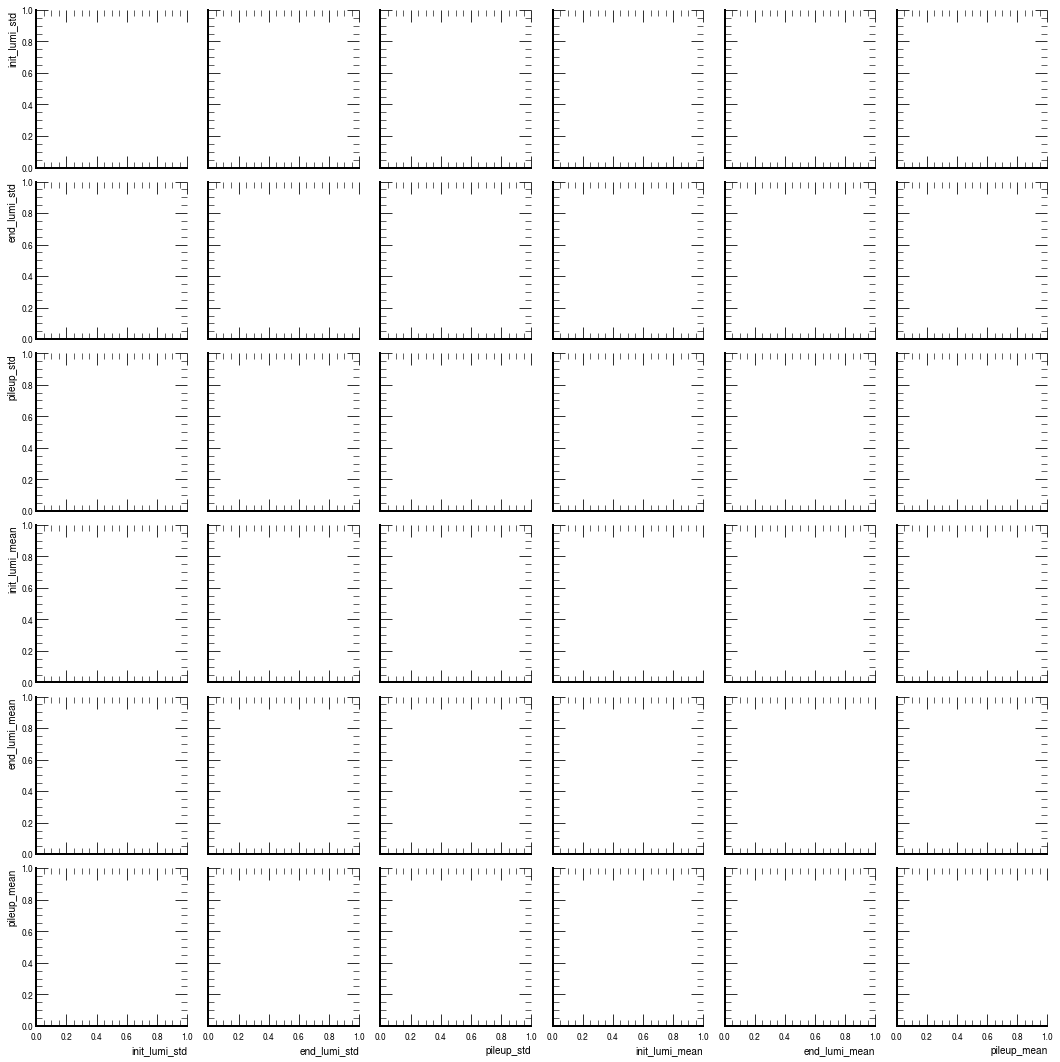

In [48]:
# Finding weights for these features
lsweights = rrr.get_weights(ls_features, plot=True)

In [ ]:
# Organizing features by order of imporance
lsfeaturelst = ls_features.columns.to_list()

lsfeatureweights_dict = {feature: round(weight, 4) for feature, weight in zip(lsfeaturelst, weights)}
lsfeatureweights_df = pd.DataFrame(list(lsfeatureweights_dict.items()), columns=["Feature", "Weight"]).sort_values("Weight", ascending=False).reset_index(drop=True)
lsfeatureweights_df

## Run + LS Features (Not finished)

In [ ]:
features = pd.concat([run_features.set_index('run_number'), ls_features], axis=1).reset_index()
features.rename(columns = {'index':'run_number'}, inplace=True)
features

In [ ]:
features.columns.to_list()

In [ ]:
weights3 = get_weights(features)
print('Fevel feature weights: ')
{feature: weight for feature, weight in zip(features.columns.to_list(), weights3)}

In [ ]:
# Without run number and temporal distance
weights3 = get_weights(features[[
    'init_lumi', 
    'end_lumi', 
    'delta_totallumi', 
    'delivered_lumi', 
    'init_lumi_std', 
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]])
print('Feature weights: ')
{feature: weight for feature, weight in zip(features[[
    'init_lumi', 
    'end_lumi', 
    'delta_totallumi', 
    'delivered_lumi', 
    'init_lumi_std', 
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]].columns.to_list(), weights3)}

- Features of importance after testing different combinations:
    - `run_number`
    - `temp_dist`
    - `init_lumi`
    - `end_lumi`
    - `init_lumi_mean`
    - `end_lumi_mean`
- Including features related to the standard deviation of a LS-lel quantity worsened the performance of the ranking considerably.
- Including `pileup_mean`, `delta_totallumi` and/or `delivered_lumi` make the ranking performance worse, but not by much if only one of these are included at a time.

In [ ]:
features_to_use = ['run_number', 'temp_dist', 'init_lumi', 'end_lumi', 'init_lumi_mean', 'end_lumi_mean']

In [ ]:
features.set_index('run_number').loc[:315267]

# Ranking With PCA

In [ ]:
importlib.reload(rrr)

In [49]:
# Features dataframe
features = pd.concat([run_features.set_index('run_number'), ls_features], axis=1).reset_index()
features.rename(columns = {'index':'run_number'}, inplace=True)
features

,run_number,init_lumi,recorded_lumi,energy,end_lumi,hlt_physics_rate,fill_number,initial_prescale_index,last_lumisection_number,l1_rate,hlt_physics_counter,delta_totallumi,temp_dist,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
0,314472.0,0.001623,0.009077,6499.0,0.001572,1649.849,6570.0,9.0,85.0,36146.520,3230527.0,-0.000051,1986562.0,0.011048,0.000741,0.000737,26.350121,0.000909,0.000927,32.349674
1,314473.0,0.001552,0.004270,6499.0,0.001536,2900.216,6570.0,3.0,13.0,39206.130,878868.0,-0.000015,1984511.0,0.006126,0.000009,0.000010,0.315599,0.001547,0.001546,55.029805
2,314474.0,0.001525,0.004117,6499.0,0.001509,3086.000,6570.0,3.0,12.0,41741.863,863231.0,-0.000016,1984098.0,0.006015,0.000008,0.000009,0.297206,0.001520,0.001519,54.064429
3,314475.0,0.001506,0.004101,6499.0,0.001486,2885.129,6570.0,3.0,13.0,39028.610,874296.0,-0.000019,1983700.0,0.005908,0.000012,0.000013,0.410320,0.001493,0.001491,53.115828
4,314476.0,0.001466,0.003833,6499.0,0.001460,2977.611,6570.0,3.0,12.0,40268.250,832912.0,-0.000006,1983281.0,0.005467,0.000009,0.000009,0.315032,0.001467,0.001466,52.169618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,316059.0,1.443949,163.122688,6499.0,1.123433,1122.926,6662.0,6.0,567.0,43362.875,14841710.0,-0.320517,40436.0,172.545656,0.098105,0.098156,2.744417,1.292595,1.292035,36.159544
182,316060.0,1.122686,187.693031,6499.0,0.698668,786.737,6662.0,3.0,935.0,43866.508,17147121.0,-0.424018,27039.0,194.266531,0.136233,0.136144,3.811026,0.883828,0.883379,24.724554
183,316061.0,0.698097,9.896375,6499.0,0.717717,312.891,6662.0,9.0,206.0,31555.443,1502485.0,0.019620,5030.0,11.908156,0.020350,0.020426,0.569269,0.690145,0.690233,19.306371
184,316062.0,0.717256,3.613719,6499.0,0.708778,293.151,6662.0,4.0,26.0,21189.146,177670.0,-0.008478,0.0,3.830469,0.359013,0.359596,10.043154,0.379452,0.363513,10.614927


In [50]:
# Features that will be considered in the ranking
features_to_use = [
    'run_number',
    'init_lumi',
#     'recorded_lumi',
#     'energy',
    'end_lumi',
#     'hlt_physics_rate',
#     'fill_number',
#     'initial_prescale_index',
#     'last_lumisection_number',
#     'l1_rate',
#     'hlt_physics_counter',
    'delta_totallumi',
#     'temp_dist',
    'delivered_lumi',
    'init_lumi_std',
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]

In [51]:
# Reformatting df for use in ranking
features['run'] = features['run_number'].astype(int)
features.set_index('run', inplace=True)
features.tail()

,run_number,init_lumi,recorded_lumi,energy,end_lumi,hlt_physics_rate,fill_number,initial_prescale_index,last_lumisection_number,l1_rate,hlt_physics_counter,delta_totallumi,temp_dist,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
run,,,,,,,,,,,,,,,,,,,,
316059,316059.0,1.443949,163.122688,6499.0,1.123433,1122.926,6662.0,6.0,567.0,43362.875,14841710.0,-0.320517,40436.0,172.545656,0.098105,0.098156,2.744417,1.292595,1.292035,36.159544
316060,316060.0,1.122686,187.693031,6499.0,0.698668,786.737,6662.0,3.0,935.0,43866.508,17147121.0,-0.424018,27039.0,194.266531,0.136233,0.136144,3.811026,0.883828,0.883379,24.724554
316061,316061.0,0.698097,9.896375,6499.0,0.717717,312.891,6662.0,9.0,206.0,31555.443,1502485.0,0.019620,5030.0,11.908156,0.020350,0.020426,0.569269,0.690145,0.690233,19.306371
316062,316062.0,0.717256,3.613719,6499.0,0.708778,293.151,6662.0,4.0,26.0,21189.146,177670.0,-0.008478,0.0,3.830469,0.359013,0.359596,10.043154,0.379452,0.363513,10.614927
316082,316082.0,1.881687,137.502563,6499.0,1.542417,1142.772,6663.0,2.0,433.0,51408.740,11534466.0,-0.339270,-7677.0,142.084781,0.568793,0.559148,15.911640,1.521491,1.529325,42.562781


In [52]:
# Initial test that ranking system actually ranks
target = 316082
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(features[features_to_use].loc[:target], target, n_components=2)
print('Ranking of RR used: ', rankings.index[rankings['run']==targetRR][0])
rankings = pd.merge(rankings.set_index("run"), features[features_to_use], left_index=True, right_index=True, how='left').reset_index()
rankings.head(10)

Ranking of RR used:  7


,run,dist,PC1,PC2,run_number,init_lumi,end_lumi,delta_totallumi,delivered_lumi,init_lumi_std,end_lumi_std,pileup_std,init_lumi_mean,end_lumi_mean,pileup_mean
0,316082,0.000000,6.763363,-0.326959,316082.0,1.881687,1.542417e+00,-0.339270,142.084781,0.568793,0.559148,15.911640,1.521491,1.529325,42.562781
1,316058,0.607791,6.251003,-0.653909,316058.0,1.863196,1.445017e+00,-0.418179,139.838953,0.472541,0.466631,13.219033,1.504431,1.507961,42.085533
2,315784,0.651837,6.295689,-0.781020,315784.0,1.910669,1.679284e+00,-0.231384,79.855625,0.535421,0.524694,14.978067,1.590925,1.598410,44.505144
3,315973,1.093367,5.713788,-0.633297,315973.0,1.807007,1.116081e+00,-0.690926,285.039938,0.316497,0.313514,8.853810,1.334724,1.335932,37.338087
4,315800,1.147967,5.782681,-0.923692,315800.0,1.885026,1.341135e+00,-0.543891,219.964172,0.355918,0.351472,9.956593,1.445831,1.447854,40.446237
5,315840,1.782947,4.988067,-0.491950,315840.0,0.921150,9.816578e-01,0.060508,354.229844,0.378289,0.378289,10.582414,1.282234,1.282234,35.869698
6,315689,1.886211,4.893219,-0.572624,315689.0,1.398032,9.074186e-01,-0.490614,342.163187,0.273139,0.270994,8.429840,1.229503,1.230248,37.945962
7,315713,2.080730,6.424629,1.726014,315713.0,1.998048,5.186500e-08,-1.998048,365.100937,0.372692,0.372692,10.834837,1.376613,1.376613,40.020698
8,315702,2.102530,5.163626,1.037399,315702.0,1.520755,1.393269e+00,-0.127485,26.410127,0.622134,0.615185,18.086584,1.057866,1.069468,30.754129
9,315555,2.380361,4.498866,-1.060557,315555.0,1.519945,1.472775e+00,-0.047170,27.501754,0.398148,0.377327,15.122156,1.304799,1.318667,49.557868


In [53]:
# Testing a case where there will not be enough candidate runs to apply ranking
target = 314472 # Oldest run in features dataframe, so nothing to compare it to
targetRR = RRfetch(target, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')
rankings = rrr.refrank_pca(features[features_to_use], target, n_components=1)
rankings

ERROR: Not enough runs to perform ranking


In [54]:
def test_ranking(features, comparison_num=60, n_components=1, print_stats=True, dpi=200):
    # Testing over many target runs to obtain better idea of performance
    RRranks = []
    results = {}

    # Loop over some of the runs that are available
    for targ in list(features.reset_index()['run'].unique())[comparison_num+1:]:
        # Get reference run
        targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/jsons/json_allRunsRefRuns.json')

        rankings = rrr.refrank_pca(features[features_to_use].loc[:targ].iloc[-comparison_num:], targ, n_components=n_components)

        # In case there are any target runs for which the number of candidate runs is 0
        if rankings is None:
            pass

        # Get the rank the actual reference got
        try: 
            actualrefrank = rankings.index[rankings['run']==targetRR][0]
            RRranks.append(actualrefrank)
            results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank}
        except: # Error due to actual reference run not being available
            pass


    results = pd.DataFrame(results).T
    
    if print_stats:
        print(results['ActualRefRank'].describe())

    fig, ax = plt.subplots(dpi=dpi)
    ax = results['ActualRefRank'].hist(bins=30)
    ax.set_title("RRR results for n={}, comparison_num={}".format(n_components, comparison_num))
    ax.set_xlabel("Rank of actual reference run")

    ax.plot([10]*10, range(0,10))

    plt.show()

In [55]:
# Features that will be considered in the ranking
features_to_use = [
    'run_number',
    'init_lumi',
#     'recorded_lumi',
#     'energy',
    'end_lumi',
#     'hlt_physics_rate',
#     'fill_number',
#     'initial_prescale_index',
#     'last_lumisection_number',
#     'l1_rate',
#     'hlt_physics_counter',
    'delta_totallumi',
    'temp_dist',
    'delivered_lumi',
    'init_lumi_std',
    'end_lumi_std',
    'pileup_std',
    'init_lumi_mean',
    'end_lumi_mean',
    'pileup_mean'
]

count    100.000000
mean      21.800000
std       15.222923
min        1.000000
25%        8.750000
50%       20.000000
75%       33.250000
max       57.000000
Name: ActualRefRank, dtype: float64


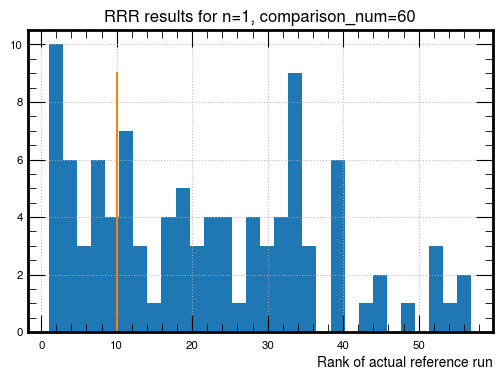

count    100.000000
mean      21.890000
std       16.672057
min        1.000000
25%        6.750000
50%       19.000000
75%       31.000000
max       59.000000
Name: ActualRefRank, dtype: float64


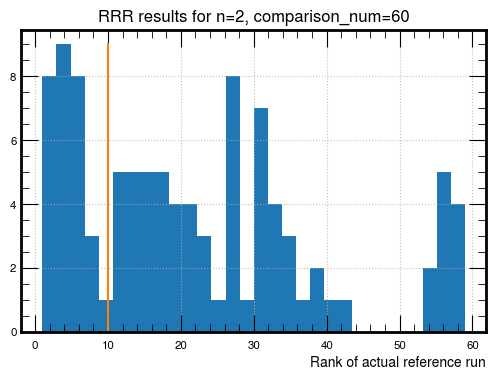

count    100.000000
mean      22.410000
std       15.202402
min        1.000000
25%       11.750000
50%       22.000000
75%       30.250000
max       59.000000
Name: ActualRefRank, dtype: float64


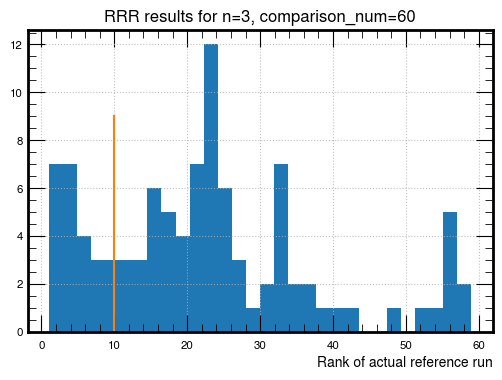

count    100.000000
mean      24.890000
std       17.157556
min        1.000000
25%       11.000000
50%       23.000000
75%       35.250000
max       59.000000
Name: ActualRefRank, dtype: float64


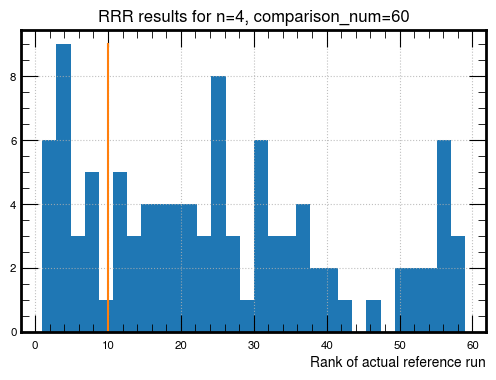

In [56]:
# Trying with temporal features
for i in range(1, 5):
    test_ranking(features[features_to_use], n_components=i, print_stats=True, dpi=100)

In [ ]:
# Re-testing, but excluding runs that have low number of LSs
isrunlong = {}
for run in lss['run_number'].unique():
    run_length = len(lss[lss['run_number']==run])
    isrunlong[run] = run_length > 700

In [ ]:
features_longruns = features.set_index('run_number')[pd.Series(isrunlong)].reset_index()
features_longruns

In [ ]:
# Testing over many target runs to obtain better idea of performance
RRranks = []
results = {}

# Loop over some of the runs that are available
for targ in list(features_longruns.reset_index()['run'].unique())[34:]:
    # Get reference run
    targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
    
    rankings = rrr.refrank_pca(features_longruns[features_to_use], targ, n_components=1)

    # In case there are any target runs for which the number of candidate runs is 0
    if rankings is None:
        pass
    
    # Get the rank the actual reference got
    actualrefrank = rankings.index[rankings['run']==targetRR][0]
    RRranks.append(actualrefrank)
    results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank}

results = pd.DataFrame(results).T
print(results['ActualRefRank'].describe())

ranksyseff = len(results[results['ActualRefRank'] <= 10])/len(results)
print('Rank system efficiency: ', ranksyseff)

fig, ax = plt.subplots(dpi=100)
ax = results['ActualRefRank'].hist(bins=30)

ax.plot([10]*10, range(0,10))

plt.show()

# # for i in range(len(features_to_use)):
# rankings = []
# results = {}

# for targ in list(features_longruns['run_number'].unique()):
#     targetRR = RRfetch(targ, jsonfile='/eos/user/r/rcruzcan/SWAN_projects/RefRunRank/utils/json_allRunsRefRuns.json')
#     features_PC = rrr.refrank_pca(features_longruns[features_to_use], targ, n_components=2)
#     actualrefrank = features_PC.index[features_PC['run_number']==targetRR]
#     if len(actualrefrank) > 0:
#         rankings.append(actualrefrank[0])
#         results[targ] = {'ActualRef': targetRR, 'ActualRefRank': actualrefrank[0]}
    
# results = pd.DataFrame(results).T
# print(results['ActualRefRank'].describe())

# ranksyseff = len(results[results['ActualRefRank'] <= 10])/len(results)
# print('Rank system efficiency: ', ranksyseff)

# fig, ax = plt.subplots(dpi=150)
# ax = results['ActualRefRank'].hist(bins=30)

# ax.plot([10]*10, range(0,10))

# plt.show()

Trying with n > 1

In [ ]:
# Standardizing
scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features[features_to_use]), columns=features[features_to_use].columns)

In [ ]:
# # PCA
# n_components = 1
# pca = PCA(n_components=n_components)
# pca.fit(features_scaled)

# features_PC = pd.DataFrame(pca.transform(features_scaled), columns=['PC'+str(i+1) for i in range(len(pca.components_))])
# features_PC = pd.concat([features['run_number'], features_PC], axis=1).set_index('run_number')

# # Getting distances
# dist = np.sqrt(((features_PC - features_PC.loc[target])**2).sum(axis=1))
# features_PC = pd.concat([dist, features_PC], axis=1)
# features_PC.rename(columns = {0:'dist'}, inplace=True)

# # Sorting by distance
# features_PC = features_PC.sort_values(by='dist', ascending=True).reset_index()

In [ ]:
# print('Ranking of RR used: ', features_PC.index[features_PC['run_number']==targetRR][0])

In [ ]:
# PCA n=1
pca = PCA(n_components=1)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red1 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1'])
features_red1 = pd.concat([features['run_number'], features_red1], axis=1).set_index('run_number')

# Getting distances
dist_n1 = (features_red1 - features_red1.loc[target]).abs()
dist_n1.rename(columns = {'PC1':'dist'}, inplace=True)
features_red1 = pd.concat([dist_n1, features_red1], axis=1)

# Sorting by distance
features_red1 = features_red1.sort_values(by='dist', ascending=True).reset_index()

In [ ]:
features_red1

With the rankings (i.e. index of `feature_red1`) for all the runs under consideration, we can get the rank of the reference run that was actually used, which is contained in `targetRR`.

In [ ]:
print('Ranking of RR used: ', features_red1.index[features_red1['run_number']==targetRR][0])

We now try with $N=2$

In [ ]:
# PCA n=2
pca = PCA(n_components=2)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red2 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1', 'PC2'])
features_red2 = pd.concat([features['run_number'], features_red2], axis=1).set_index('run_number')

# Computing Eucledian distances
dist_n2 = np.sqrt(((features_red2 - features_red2.loc[target])**2).sum(axis=1))
features_red2 = pd.concat([dist_n2, features_red2], axis=1)
features_red2.rename(columns = {0:'dist'}, inplace=True)
features_red2 = features_red2.sort_values(by='dist', ascending=True).reset_index()

In [ ]:
features_red2

In [ ]:
print('Ranking of RR used: ', features_red2.index[features_red2['run_number']==targetRR][0])

Trying $N=3$...

In [ ]:
# PCA n=3
pca = PCA(n_components=3)
pca.fit(features_scaled)

# Projecting data to sub-space
features_red3 = pd.DataFrame(pca.transform(features_scaled), columns=['PC1', 'PC2', 'PC3'])
features_red3 = pd.concat([features['run_number'], features_red3], axis=1).set_index('run_number')

# Computing Eucledian distances
dist_n3 = np.sqrt(((features_red3 - features_red3.loc[target])**2).sum(axis=1))
features_red3 = pd.concat([dist_n3, features_red3], axis=1)
features_red3.rename(columns = {0:'dist'}, inplace=True)
features_red3 = features_red3.sort_values(by='dist', ascending=True).reset_index()

In [ ]:
features_red3

In [ ]:
print('Ranking of RR used: ', features_red3.index[features_red3['run_number']==targetRR][0])